In [107]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.colors as mcolors

In [108]:

# Rotation angle in degrees
theta_deg = 0
theta = np.radians(theta_deg)
resolution = 10

# Constants
D = 100
U_G = 11.87
z_h = 100
C_star = 4.5
f = 1e-4
k = 0.4
z_0lo = 0.0001

# Corresponding thrust coefficients C_T [-]   ->   3 m/s to 19 m/s
C_T_values = np.array([0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.80, 0.78, 0.65, 0.55, 0.50, 0.40, 0.35, 0.30, 0.28, 0.25])

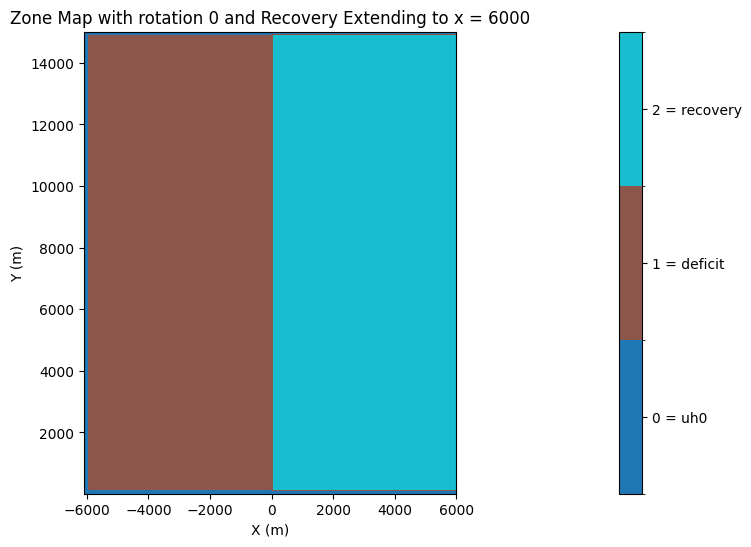

In [109]:
def create_wind_farm_mask(corner_points, resolution=10, mirror_axis=None, recovery_x_end=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align rightmost (downstream) edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Align bottom of park to y = 0
    min_y = points[:, 1].min()
    points[:, 1] -= min_y

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Expand x and y bounds slightly
    x_padding = 100  # meters
    y_padding = 100  # meters
    min_x -= x_padding
    min_y -= y_padding
    if recovery_x_end is not None:
        max_x = max(max_x, recovery_x_end)
    max_y += y_padding


    # Create y_range
    y_highres_bottom = np.array([])
    y_normal = np.arange(min_y, max_y + resolution, resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal])

    # Create x_range with extended domain
    x_range = np.arange(min_x, max_x + resolution, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range


# --- Define park shape ---
#corner_points = [(0, 0), (200, 0), (200, 100),(150, 100), (150, 50), (50, 50), (50, 100),(0, 100)]
corner_points = [(0, 0), (300, 0), (300, 150), (0, 150)] # Rectangle
#corner_points = [(0, 0), (300, 0), (300, 100), (200, 100), (200, 50), (100, 50), (100, 100), (0, 100)] # U-shape
#corner_points = [(0, 0), (150, 0), (150, 50), (50, 50), (50, 150), (0, 150)] # L-shape
#corner_points = [(0, 0), (200, 0), (200, 50), (125, 50), (125, 100), (200, 100), (200, 150), (0, 150), (0, 100), (75, 100), (75, 50), (0, 50)] # Hourglass
corner_points = [(x * 20, y * 100) for x, y in corner_points]
rotation_degrees = theta_deg
mirror_axis = 'x'
recovery_x_end = 6000  # set recovery limit

# Generate mask
mask_2d, x_range, y_range = create_wind_farm_mask(
    corner_points,
    resolution=resolution,
    mirror_axis=mirror_axis,
    recovery_x_end=recovery_x_end  # pass to extend x_range
)

# --- Zone classification ---
ZONE_UH0 = 0
ZONE_DEFICIT = 1
ZONE_RECOVERY = 2

zone_map = np.full(mask_2d.shape, ZONE_UH0, dtype=int)

for row_idx, row in enumerate(mask_2d):
    true_indices = np.where(row == 1)[0]

    if true_indices.size > 0:
        # Identify gaps between clusters of ones
        diffs = np.diff(true_indices)
        split_points = np.where(diffs > 1)[0]
        segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
        segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]

        # Mark each deficit segment
        for start, end in zip(segment_starts, segment_ends):
            zone_map[row_idx, start:end + 1] = ZONE_DEFICIT

        # Mark gaps in between as recovery
        for i in range(len(segment_ends) - 1):
            gap_start = segment_ends[i] + 1
            gap_end = segment_starts[i + 1] - 1
            if gap_start <= gap_end:
                zone_map[row_idx, gap_start:gap_end + 1] = ZONE_RECOVERY

        # Mark recovery zone after the last deficit
        last_farm_x = x_range[segment_ends[-1]]
        recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
        zone_map[row_idx, recovery_indices] = ZONE_RECOVERY


# --- Plot ---
plt.figure(figsize=(10, 6))

row_indices = np.where(mask_2d.any(axis=1))[0]
park_y_min = y_range[row_indices[0]]
park_y_max = y_range[min(row_indices[-1] + 1, len(y_range) - 1)]

extent = [x_range[0], x_range[-1], park_y_min, park_y_max]

# Define a discrete colormap with 3 colors (you can choose your own)
cmap = mcolors.ListedColormap(['#1f77b4', '#8c564b', '#17becf'])  # Blue, Brown, Cyan
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
im = plt.imshow(zone_map, origin='lower', extent=extent, cmap=cmap, norm=norm, aspect='auto')
cbar = plt.colorbar(im, ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(['0 = uh0', '1 = deficit', '2 = recovery'])

plt.title(f"Zone Map with rotation {theta_deg} and Recovery Extending to x = {recovery_x_end}")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis('scaled')
plt.ylim(park_y_min, park_y_max)
plt.show()

In [110]:
y_resolution = 10
U_h0 = 10 # [m/s]

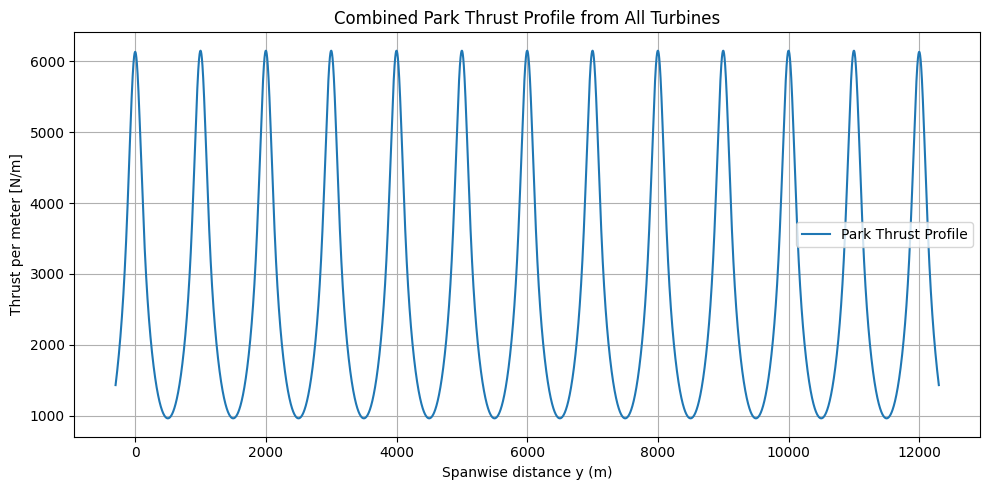

Integrated thrust from profile: 33642132.83 N
Expected total thrust:          34145381.50 N
Thrust deviation: -1.47 %
Normalized thrust profile integral: 1.000000


/var/folders/j6/19hd1bln7bx6375t_4njz15w0000gn/T/ipykernel_42646/1810155594.py:71: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  total_thrust_from_profile = simps(Park_Thrust_Profile, y)
/var/folders/j6/19hd1bln7bx6375t_4njz15w0000gn/T/ipykernel_42646/1810155594.py:82: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  normalized_integral = simps(Park_Thrust_Profile_normalized, y)


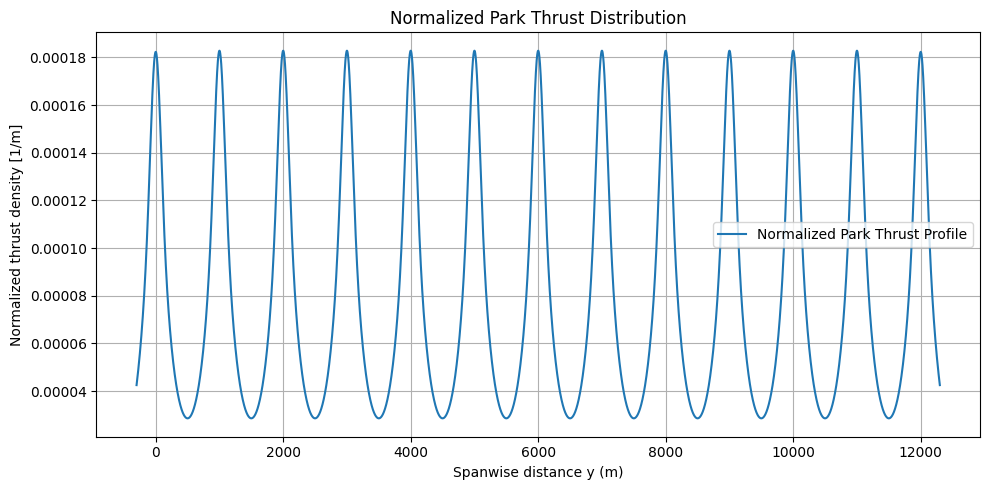

In [111]:
k_star = 0.05

# Turbine positions
turbine_positions = [
    (-6000, 0), (-5000, 0), (-4000, 0), (-3000, 0), (-2000, 0), (-1000, 0), (0, 0),
    (-6000, 1000), (-5000, 1000), (-4000, 1000), (-3000, 1000), (-2000, 1000), (-1000, 1000), (0, 1000),
    (-6000, 2000), (-5000, 2000), (-4000, 2000), (-3000, 2000), (-2000, 2000), (-1000, 2000), (0, 2000),
    (-6000, 3000), (-5000, 3000), (-4000, 3000), (-3000, 3000), (-2000, 3000), (-1000, 3000), (0, 3000),
    (-6000, 4000), (-5000, 4000), (-4000, 4000), (-3000, 4000), (-2000, 4000), (-1000, 4000), (0, 4000),
    (-6000, 5000), (-5000, 5000), (-4000, 5000), (-3000, 5000), (-2000, 5000), (-1000, 5000), (0, 5000),
    (-6000, 6000), (-5000, 6000), (-4000, 6000), (-3000, 6000), (-2000, 6000), (-1000, 6000), (0, 6000),
    (-6000, 7000), (-5000, 7000), (-4000, 7000), (-3000, 7000), (-2000, 7000), (-1000, 7000), (0, 7000),
    (-6000, 8000), (-5000, 8000), (-4000, 8000), (-3000, 8000), (-2000, 8000), (-1000, 8000), (0, 8000),
    (-6000, 9000), (-5000, 9000), (-4000, 9000), (-3000, 9000), (-2000, 9000), (-1000, 9000), (0, 9000),
    (-6000, 10000), (-5000, 10000), (-4000, 10000), (-3000, 10000), (-2000, 10000), (-1000, 10000), (0, 10000),
    (-6000, 11000), (-5000, 11000), (-4000, 11000), (-3000, 11000), (-2000, 11000), (-1000, 11000), (0, 11000),
    (-6000, 12000), (-5000, 12000), (-4000, 12000), (-3000, 12000), (-2000, 12000), (-1000, 12000), (0, 12000)
]

# Coordinate sets for turbines
unique_y_coords = set(pos[1] for pos in turbine_positions)

# Park Wind Profile Array (spanwise axis)
y_min = min(unique_y_coords) - 3 * D
y_max = max(unique_y_coords) + 3 * D
y = np.linspace(y_min, y_max, int((y_max - y_min) + 1))  # 1-meter resolution
Park_Wind_Profile = np.full_like(y, U_h0)

# Define downstream edge
max_x_turbine = max(pos[0] for pos in turbine_positions)
downstream_edge = max_x_turbine + 10 * D

# Compute b and epsilon (ε)
b = 0.5 * (1 + np.sqrt(1 - C_T_values[U_h0-2])) / np.sqrt(1 - C_T_values[U_h0-2])
epsilon = 0.2 * np.sqrt(b)

rho = 1.225  # Air density [kg/m³]
A_rotor = 0.25 * np.pi * D**2  # Rotor area

# Initialize thrust distribution across y
Park_Thrust_Profile = np.zeros_like(y)

for (x_turb, y_turb) in turbine_positions:
    x = downstream_edge - x_turb
    s = k_star * x / D + epsilon  # Spread parameter
    sigma = s * D  # Standard deviation of Gaussian

    # Turbine thrust [N] assuming freestream wind
    T_turbine = 0.5 * rho * A_rotor * C_T_values[U_h0-2] * U_h0**2

    # Spanwise thrust density profile
    y_local = y - y_turb
    thrust_density = (T_turbine / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (y_local / sigma)**2)

    # Add this turbine's contribution to the total Park Thrust Profile
    Park_Thrust_Profile += thrust_density

# Plot the final thrust profile
plt.figure(figsize=(10, 5))
plt.plot(y, Park_Thrust_Profile, label="Park Thrust Profile")
plt.xlabel("Spanwise distance y (m)")
plt.ylabel("Thrust per meter [N/m]")
plt.title("Combined Park Thrust Profile from All Turbines")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from scipy.integrate import simps

total_thrust_from_profile = simps(Park_Thrust_Profile, y)
expected_total_thrust = len(turbine_positions) * 0.5 * rho * A_rotor * C_T_values[U_h0-2] * U_h0**2

print(f"Integrated thrust from profile: {total_thrust_from_profile:.2f} N")
print(f"Expected total thrust:          {expected_total_thrust:.2f} N")
print(f"Thrust deviation: {100 * (total_thrust_from_profile - expected_total_thrust) / expected_total_thrust:.2f} %")

# Normalize thrust profile
Park_Thrust_Profile_normalized = Park_Thrust_Profile / total_thrust_from_profile

# Check: integrate normalized profile to verify it sums to 1
normalized_integral = simps(Park_Thrust_Profile_normalized, y)
print(f"Normalized thrust profile integral: {normalized_integral:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(y, Park_Thrust_Profile_normalized, label="Normalized Park Thrust Profile")
plt.xlabel("Spanwise distance y (m)")
plt.ylabel("Normalized thrust density [1/m]")
plt.title("Normalized Park Thrust Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
# Original spacings
s_x = 10.0
s_y = 10.0

# Define the unit vectors in original directions
dx = np.array([s_x, 0])
dy = np.array([0, s_y])

# Rotation matrix
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

# Rotate the unit vectors
dx_rot = R @ dx
dy_rot = R @ dy

# Projected spacings along global x and y
s_x_global = np.abs(dx_rot)
s_y_global = np.abs(dy_rot)

s_x = s_x_global[0] + s_x_global[1]
s_y = s_y_global[0] + s_y_global[1]

print(f"s_x: {s_x}, s_y: {s_y}")

s_x: 10.0, s_y: 10.0
